In [2]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

from ctrace.simulation import *
from ctrace.recommender import *
from ctrace.problem import *
from ctrace.utils import *
from ctrace import PROJECT_ROOT

## Digital CT Algorithms ##

In [ ]:
'''def DegGreedy_private_V2(state: InfectionState, epsilon: float):
    weights: List[Tuple[int, int]] = []
    
    I2 = set(state.SIR.I2)
    for u in state.V1:
        ngbrs = set(state.G.neighbors(u))
        deg_noise_V2 = sum([1 for i in ngbrs if i in state.V2 and state.Q[u][i]!=0])
        infected_nbr_count = sum([1 for v in ngbrs if v in I2])
        
        deg_noise_V2 += sample_dgauss(1/(math.sqrt(2)*epsilon/2))
        #deg_noise_V2 += sample_dgauss(1/((1/math.sqrt(10))*epsilon))
        #1/sqrt(10)
        infected_nbr_count += sample_dgauss(1/(math.sqrt(2)*epsilon/2))
        #infected_nbr_count += sample_dgauss(1/((3/math.sqrt(10))*epsilon))
        #3/sqrt(10)
        
        w_sum = state.transmission_rate * max(1, deg_noise_V2)
        
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, infected_nbr_count))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    
    return {i[1] for i in weights[:state.budget]}'''

def DegGreedy_private_product(state: InfectionState, epsilon: float):
    weights: List[Tuple[int, int]] = []
    
    I2 = set(state.SIR.I2)
    for u in state.V1:
        ngbrs = set(state.G.neighbors(u))
        deg_V2 = sum([1 for i in ngbrs if i in state.V2 and state.Q[u][i]!=0])
        infected_nbr_count = len([v for v in ngbrs if v in I2])
        
        noise_delta = max(deg_V2, infected_nbr_count)
        noise = sample_dgauss(noise_delta/epsilon)
        
        weights.append((max(0, noise+deg_V2*infected_nbr_count), u))
    weights.sort(reverse=True)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_I_noisy(state: InfectionState, epsilon: float):
    degrees: List[Tuple[int, int]] = []
    
    infected_set = set(state.SIR.I2)
    
    for u in state.V1:
        noise = sample_dgauss(1/epsilon)
        count = max(1, sum([1 for i in set(state.G.neighbors(u)) if i in infected_set]) + noise)
        degrees.append((count, u))
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

def List_Length_Noisy(state: InfectionState, epsilon: float):
    degrees: List[Tuple[int, int]] = []
    
    noise = 0
    v1_to_score = {}
    for i in state.SIR.I2:
        v1_neighbors = [v for v in state.G.neighbors(i) if v in state.V1]
        
        for v in v1_neighbors:
            noise = max(noise, 1/len(v1_neighbors))
            if v in v1_to_score:
                v1_to_score[v] += 1/len(v1_neighbors)
            else:
                v1_to_score[v] = 1/len(v1_neighbors)
    
    degrees = [(value + sample_dgauss(noise/epsilon), key) for key, value in v1_to_score.items()]
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

'''def List_Length(state: InfectionState, epsilon: float):
    degrees: List[Tuple[int, int]] = []
    
    v1_to_score = {}
    for i in state.SIR.I2:
        v1_neighbors = [v for v in state.G.neighbors(i) if v in state.V1]
        
        for v in v1_neighbors:
        
            if v in v1_to_score:
                v1_to_score[v] += 1/len(v1_neighbors)
            else:
                v1_to_score[v] = 1/len(v1_neighbors)
    
    degrees = [(value, key) for key, value in v1_to_score.items()]
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}'''

def NoIntervention(state: InfectionState, epsilon: float):
    return set()

### Epicurves ###

##### Montgomery

In [60]:
with open(PROJECT_ROOT/"output"/"mont_digital_epicurve_3.json") as f:
    I_digital = json.load(f)

##### Albemarle

In [119]:
with open(PROJECT_ROOT/"output"/"albe_digital_epicurve_4.json") as f:
    I_digital = json.load(f)

##### Montomgery*

In [76]:
with open(PROJECT_ROOT/"output"/"mont_star_digital_epicurve_3.json") as f:
    I_digital = json.load(f)

##### Albemarle*

In [87]:
with open(PROJECT_ROOT/"output"/"albe_star_digital_epicurve_3.json") as f:
    I_digital = json.load(f)

##### Graph Epicurve

In [120]:
size = max(len(l) for l in I_digital.values())

I_output = {}
for alg, l in I_digital.items():
    I_output[alg] = [j for j in l]+(size-len(l))*[0]

Text(0.5, 0, 'Timestep')

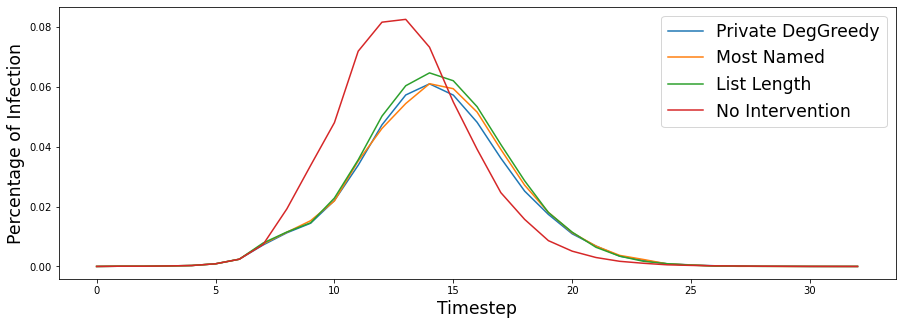

In [121]:
fig = plt.figure(figsize = (15, 5))

sns.lineplot(x=[i for i in range(size)], y = I_output["DegGreedy_private_product"])
sns.lineplot(x=[i for i in range(size)], y = I_output["Degree_I_noisy"])
sns.lineplot(x=[i for i in range(size)], y = I_output["List_Length_Noisy"])
sns.lineplot(x=[i for i in range(size)], y = I_output["NoIntervention"])

legend_name = ["Private DegGreedy", "Most Named", "List Length", "No Intervention"]
plt.legend(legend_name, fontsize = 'xx-large')

plt.ylabel("Percentage of Infection", fontsize = 'xx-large')
plt.xlabel("Timestep", fontsize = 'xx-large')
#plt.xlim([0, 28])

In [68]:
fig.savefig("../output/plots/digital_epicurve_mont.png", dpi=500, bbox_inches = 'tight')

In [106]:
fig.savefig("../output/plots/digital_epicurve_albe_2.png", dpi=500, bbox_inches = 'tight')

In [80]:
fig.savefig("../output/plots/digital_epicurve_mont_star.png", dpi=500, bbox_inches = 'tight')

In [91]:
fig.savefig("../output/plots/digital_epicurve_albe_star.png", dpi=500, bbox_inches = 'tight')

#### Combined Epicurve Plots

##### Montgomery

In [11]:
with open(PROJECT_ROOT/"output"/"mont_combined_epicurve.json", "r") as f:
    data = json.load(f)
    I_full = [list(data["I_full"]["NoIntervention"]), list(data["I_full"]["EC"]),
              list(data["I_full"]["DepRound_fair"]), list(data["I_full"]["DegGreedy_fair"])]
    I_digital = [list(data["I_digital"]["NoIntervention"]), list(data["I_digital"]["List_Length_Noisy"]),
                 list(data["I_digital"]["Degree_I_noisy"]), list(data["I_digital"]["DegGreedy_private_product"])]
    I_manual = [list(data["I_manual"]["NoIntervention"]), list(data["I_manual"]["Random"]),
               list(data["I_manual"]["SegDegree"])]

##### Albemarle

In [6]:
with open(PROJECT_ROOT/"output"/"albe_combined_epicurve.json", "r") as f:
    data = json.load(f)
    I_full = [list(data["I_full"]["NoIntervention"]), list(data["I_full"]["EC"]),
              list(data["I_full"]["DepRound_fair"]), list(data["I_full"]["DegGreedy_fair"])]
    I_digital = [list(data["I_digital"]["NoIntervention"]), list(data["I_digital"]["List_Length_Noisy"]),
                 list(data["I_digital"]["Degree_I_noisy"]), list(data["I_digital"]["DegGreedy_private_product"])]
    I_manual = [list(data["I_manual"]["NoIntervention"]), list(data["I_manual"]["Random"]),
               list(data["I_manual"]["SegDegree"])]

##### Montomgery*

In [34]:
with open(PROJECT_ROOT/"output"/"mont_star_combined_epicurve.json", "r") as f:
    data = json.load(f)
    I_full = [list(data["I_full"]["NoIntervention"]), list(data["I_full"]["EC"]),
              list(data["I_full"]["DepRound_fair"]), list(data["I_full"]["DegGreedy_fair"])]
    I_digital = [list(data["I_digital"]["NoIntervention"]), list(data["I_digital"]["List_Length_Noisy"]),
                 list(data["I_digital"]["Degree_I_noisy"]), list(data["I_digital"]["DegGreedy_private_product"])]
    I_manual = [list(data["I_manual"]["NoIntervention"]), list(data["I_manual"]["Random"]),
               list(data["I_manual"]["SegDegree"])]

##### Albemarle*

In [38]:
with open(PROJECT_ROOT/"output"/"albe_star_combined_epicurve.json", "r") as f:
    data = json.load(f)
    I_full = [list(data["I_full"]["NoIntervention"]), list(data["I_full"]["EC"]),
              list(data["I_full"]["DepRound_fair"]), list(data["I_full"]["DegGreedy_fair"])]
    I_digital = [list(data["I_digital"]["NoIntervention"]), list(data["I_digital"]["List_Length_Noisy"]),
                 list(data["I_digital"]["Degree_I_noisy"]), list(data["I_digital"]["DegGreedy_private_product"])]
    I_manual = [list(data["I_manual"]["NoIntervention"]), list(data["I_manual"]["Random"]),
               list(data["I_manual"]["SegDegree"])]

Text(0.5, 0, 'Timestep')

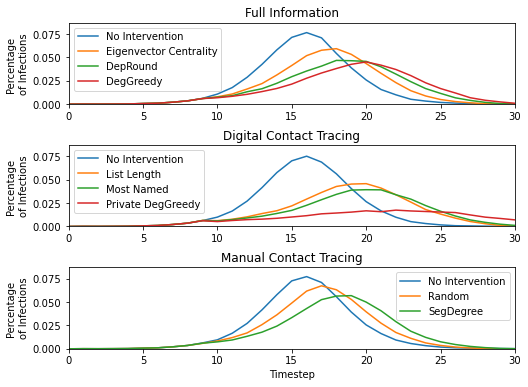

In [12]:
import json
fig, ax = plt.subplots(3,1,figsize=(8,6))

names = ["Full Information", "Digital Contact Tracing", "Manual Contact Tracing"]

legend = [["No Intervention", "Eigenvector Centrality", "DepRound", "DegGreedy"],
          ["No Intervention",  "List Length", "Most Named","Private DegGreedy" ],
          ["No Intervention", "Random", "SegDegree"]]

max_infection = max([max(i) for i in I_full+I_digital+I_manual])
max_timestep = max([len(i) for i in I_full+I_digital+I_manual])
space = 0.01

for ind, I_list in enumerate([I_full, I_digital, I_manual]):
    for l in I_list:
        ax[ind].plot(list(range(max_timestep)), l+(max_timestep-len(l))*[0])
    ax[ind].set_title(names[ind])
    ax[ind].set_xlim(0, 30)
    ax[ind].set_ylim(0, max_infection+space)
    ax[ind].legend(legend[ind])
    ax[ind].set_ylabel("Percentage \nof Infections")

fig.subplots_adjust(hspace = 0.5)
ax[2].set_xlabel("Timestep")

Text(0.5, 0, 'Timestep')

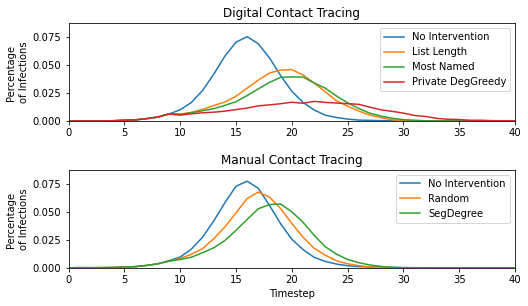

In [17]:
import json
fig, ax = plt.subplots(2,1,figsize=(8,4.5))

names = ["Digital Contact Tracing", "Manual Contact Tracing"]

legend = [["No Intervention",  "List Length", "Most Named","Private DegGreedy" ],
          ["No Intervention", "Random", "SegDegree"]]

max_infection = max([max(i) for i in I_digital+I_manual])
max_timestep = max([len(i) for i in I_digital+I_manual])
space = 0.01

for ind, I_list in enumerate([I_digital, I_manual]):
    for l in I_list:
        ax[ind].plot(list(range(max_timestep)), l+(max_timestep-len(l))*[0])
    ax[ind].set_title(names[ind])
    ax[ind].set_xlim(0, 40)
    ax[ind].set_ylim(0, max_infection+space)
    ax[ind].legend(legend[ind])
    ax[ind].set_ylabel("Percentage \nof Infections")

fig.subplots_adjust(hspace = 0.5)
ax[1].set_xlabel("Timestep")

In [18]:
fig.savefig("../output/plots/mont_combined_epicurve_nofull.png", dpi=500, bbox_inches = 'tight')

In [ ]:
fig.savefig("../output/plots/mont_combined_epicurve.png", dpi=500, bbox_inches = 'tight')

In [31]:
fig.savefig("../output/plots/albe_combined_epicurve.png", dpi=500, bbox_inches = 'tight')

In [37]:
fig.savefig("../output/plots/mont_star_combined_epicurve.png", dpi=500, bbox_inches = 'tight')

In [40]:
fig.savefig("../output/plots/albe_star_combined_epicurve.png", dpi=500, bbox_inches = 'tight')

### Digital Budget Sensitivity Plots ###

In [3]:
df_mont_digital = pd.read_csv(PROJECT_ROOT/"output"/"run_ZZgXt/results.csv")
df_albe_digital = pd.read_csv(PROJECT_ROOT/"output"/"run_RbCR6/results.csv")
df_albe_extra_digital = pd.read_csv(PROJECT_ROOT/"output"/"run_iUvfZ/results.csv")
#df_albe_extra_digital = pd.read_csv(PROJECT_ROOT/"output"/"run_AxiZM/results.csv")
#df_albe_extra_digital = pd.read_csv(PROJECT_ROOT/"output"/"run_dxvKR/results.csv")
df_mont_extra_digital = pd.read_csv(PROJECT_ROOT/"output"/"run_WtGpN/results.csv")
df = pd.concat([df_mont_digital, df_albe_digital, df_albe_extra_digital, df_mont_extra_digital])

df = df.rename(columns={"agent":"Alg for MinExposed"})
df = pd.concat([df[df["Alg for MinExposed"] == "NoIntervention"],
                df[df["Alg for MinExposed"] == "List_Length_Noisy"],
                df[df["Alg for MinExposed"] == "Degree_I_noisy"],
                df[df["Alg for MinExposed"] == "DegGreedy_private_product"]])

df["infection_list"] = df["infections_step"].apply(lambda x: [int(i) for i in x.strip("[]").split(", ")])
df["time_steps"] = df["infection_list"].apply(lambda x: len(x))
df["time_step_peak"] = df["infection_list"].apply(lambda x: x.index(max(x)))
df["peak_count"] = df["infection_list"].apply(lambda x: max(x))

def size(name: str):
    if name[0] == "c": return 131219
    else: return 75457

df["infected"] = df.apply(lambda x: 100.0*x["infection_count"]/size(x["G"]), axis = 1)
df["peak"] = df.apply(lambda x: 100.0*x["peak_count"]/size(x["G"]), axis = 1)


df_mont_digital = df[df["G"]=="montgomery"]
df_cville_digital = df[df["G"]=="cville"]
df_mont_star_digital = df[df["G"]=="montgomery_extra"]
df_cville_star_digital = df[df["G"]=="cville_extra"]

##### Total Infection Plot (with augmentation)

[None, None]

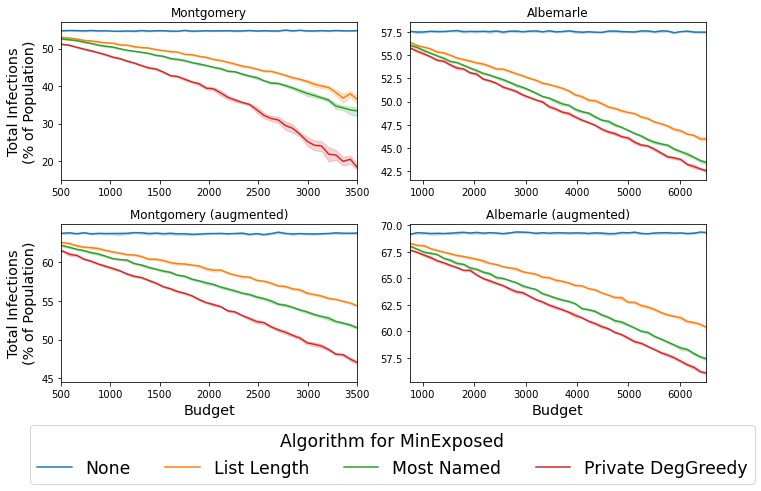

In [4]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

mont_bottom_lim = 500
mont_top_lim = 3500
albe_bottom_lim = 750
albe_top_lim = 6500

data = [data_info("Montgomery", df_mont_digital,(mont_bottom_lim, mont_top_lim), (df_mont_digital['budget'].min(), df_mont_digital['budget'].max())),
        data_info("Albemarle", df_cville_digital, (albe_bottom_lim, albe_top_lim), (df_cville_digital['budget'].min(), df_cville_digital['budget'].max())),
        data_info("Montgomery (augmented)",df_mont_star_digital, (mont_bottom_lim, mont_top_lim), (df_mont_star_digital['budget'].min(), df_mont_star_digital['budget'].max())),
        data_info("Albemarle (augmented)", df_cville_star_digital, (albe_bottom_lim, albe_top_lim), (df_cville_star_digital['budget'].min(), df_cville_star_digital['budget'].max()))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2 + col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        #a.axvline(x=data[row*2 + col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        #a.axvline(x=data[row*2 + col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        #a.axvspan(data[row*2 + col].x_range[0], data[row*2 + col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2 + col].x_lim[0],data[row*2 + col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
        
        a.set_title(data[row*2+col].title)

fig.tight_layout()

legend = fig.legend(["None", "List Length", "Most Named", "Private DegGreedy"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
#legend = fig.legend(["None", "List Length", "Most Named", "Private DegGreedy"], title='Algorithm for MinExposed',loc = "center left", ncol = 1, bbox_to_anchor = (1, 0.5), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

##### Total Infection Plot (without augmentation)

[None, None]

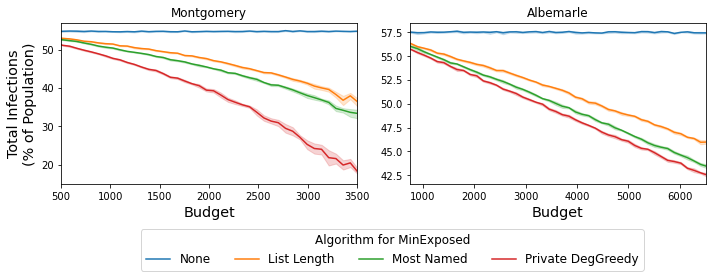

In [4]:
fig, ax = plt.subplots(1,2,figsize=(10, 3.25))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

mont_bottom_lim = 500
mont_top_lim = 3500
albe_bottom_lim = 750
albe_top_lim = 6500

data = [data_info("Montgomery", df_mont_digital,(mont_bottom_lim, mont_top_lim), (df_mont_digital['budget'].min(), df_mont_digital['budget'].max())),
        data_info("Albemarle", df_cville_digital, (albe_bottom_lim, albe_top_lim), (df_cville_digital['budget'].min(), df_cville_digital['budget'].max()))]

row = 0
for col, a in enumerate(ax):
    ax_plot = sns.lineplot(data=data[row*2 + col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
    ax_plot.get_legend().remove()
    a.set_xlim(data[row*2 + col].x_lim[0],data[row*2 + col].x_lim[1])

    if col != 0:
        a.set_ylabel("")
    else:
        a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')

    if row != 0:
        a.set_xlabel("")
    else:
        a.set_xlabel("Budget", fontsize='x-large')

    a.set_title(data[row*2+col].title)

fig.tight_layout()

legend = fig.legend(["None", "List Length", "Most Named", "Private DegGreedy"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.2), fontsize = "large")
plt.setp(legend.get_title(), fontsize='large')

In [31]:
fig.savefig("../output/plots/budget_sensitivity_digital_noaugment.png", dpi=500, bbox_inches = 'tight')

##### Peak Percentage Plot

[None, None]

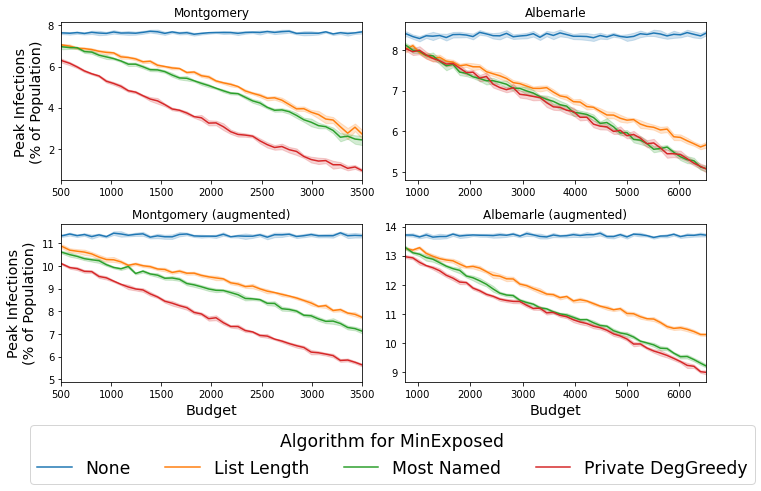

In [6]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

mont_bottom_lim = 500
mont_top_lim = 3500
albe_bottom_lim = 750
albe_top_lim = 6500

data = [data_info("Montgomery", df_mont_digital,(mont_bottom_lim, mont_top_lim), (df_mont_digital['budget'].min(), df_mont_digital['budget'].max())),
        data_info("Albemarle", df_cville_digital, (albe_bottom_lim, albe_top_lim), (df_cville_digital['budget'].min(), df_cville_digital['budget'].max())),
        data_info("Montgomery (augmented)",df_mont_star_digital, (mont_bottom_lim, mont_top_lim), (df_mont_star_digital['budget'].min(), df_mont_star_digital['budget'].max())),
        data_info("Albemarle (augmented)", df_cville_star_digital, (albe_bottom_lim, albe_top_lim), (df_cville_star_digital['budget'].min(), df_cville_star_digital['budget'].max()))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2 + col].df, x="budget", y="peak", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        #a.axvline(x=data[row*2 + col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        #a.axvline(x=data[row*2 + col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        #a.axvspan(data[row*2 + col].x_range[0], data[row*2 + col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2 + col].x_lim[0],data[row*2 + col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Peak Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
        
        a.set_title(data[row*2+col].title)

fig.tight_layout()

legend = fig.legend(["None", "List Length", "Most Named", "Private DegGreedy"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
#legend = fig.legend(["None", "List Length", "Most Named", "Private DegGreedy"], title='Algorithm for MinExposed',loc = "center left", ncol = 1, bbox_to_anchor = (1, 0.5), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

#fig.savefig("../output/plots/budget_sensitivity_digital_3_side.png", dpi=500, bbox_inches = 'tight')

In [7]:
fig.savefig("../output/plots/budget_sensitivity_digital_peak.png", dpi=500, bbox_inches = 'tight')

### Full and Manual Budget Sensitivity Plots

In [32]:
df_mont = pd.read_csv(PROJECT_ROOT / "output" / "run_XK2Wx" / "results.csv")
df_mont = pd.concat([df_mont, pd.read_csv(PROJECT_ROOT / "output" / "run_YSarn" / "results.csv")])
df_mont = pd.concat([df_mont, pd.read_csv(PROJECT_ROOT / "output" / "run_gKts5" / "results.csv")])    #Full baselines
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_H4uxJ" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
#df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_PzsWx" / "results.csv")
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_KJTdk" / "results.csv")
df_mont = pd.concat([df_mont, df_digital_part1, df_digital_part2,
                     pd.read_csv(PROJECT_ROOT / "output" / "run_hcjwx" / "results.csv")])    #Digital

df_cville = pd.read_csv(PROJECT_ROOT / "output" / "run_HHUqV" / "results.csv")
df_cville = pd.concat([df_cville, pd.read_csv(PROJECT_ROOT / "output" / "run_nRBkk" / "results.csv")])
df_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_KGnVy" / "results.csv")
df_part1 = df_part1[df_part1["budget"]<= 1500]                                                         #Full baselines (part 1)
df_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_Hvk8W" / "results.csv")                          #Full baselines (part 2)
df_cville = pd.concat([df_cville, df_part1, df_part2])
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_3egJD" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
#df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_NVHEx" / "results.csv")
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_XPaLy" / "results.csv")
df_cville = pd.concat([df_cville, df_digital_part1, df_digital_part2, 
                       pd.read_csv(PROJECT_ROOT / "output" / "run_628MK" / "results.csv")])
#df_cville = pd.concat([df_cville, pd.read_csv(PROJECT_ROOT / "output" / "run_3egJD" / "results.csv")]) #Digital

df_mont_edges = pd.read_csv(PROJECT_ROOT / "output" / "run_Txksw" / "results.csv")
df_mont_edges = pd.concat([df_mont_edges, pd.read_csv(PROJECT_ROOT / "output" / "run_4AUu7" / "results.csv")])
df_mont_edges = pd.concat([df_mont_edges, pd.read_csv(PROJECT_ROOT / "output" / "run_2gPBD" / "results.csv")])    #Full baselines
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_Xfgpk" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
#df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_dTJcu" / "results.csv")
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_WMsMV" / "results.csv")
df_mont_edges = pd.concat([df_mont_edges, df_digital_part1, df_digital_part2,
                           pd.read_csv(PROJECT_ROOT / "output" / "run_5Qnke" / "results.csv")])    #Digital

df_cville_edges = pd.read_csv(PROJECT_ROOT / "output" / "run_X9z7Y" / "results.csv")
df_cville_edges = pd.concat([df_cville_edges, pd.read_csv(PROJECT_ROOT / "output" / "run_T9eDX" / "results.csv")])
df_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_6TLVb" / "results.csv")                                       #Full baselines
df_part1 = df_part1[df_part1["budget"]<=1700]
df_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_KXypB" / "results.csv")
df_part2 = df_part2[df_part2["budget"]>=1700]
df_cville_edges = pd.concat([df_cville_edges,  df_part1, df_part2]) #Full baseline
df_digital_part1 = pd.read_csv(PROJECT_ROOT / "output" / "run_FSL2A" / "results.csv")
df_digital_part1 = df_digital_part1[df_digital_part1["agent"]=="Degree_V2_noisy"]
#df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_dpLvN" / "results.csv")
df_digital_part2 = pd.read_csv(PROJECT_ROOT / "output" / "run_HRus6" / "results.csv")
df_cville_edges = pd.concat([df_cville_edges, df_digital_part1, df_digital_part2,
                            pd.read_csv(PROJECT_ROOT / "output" / "run_AiNft" / "results.csv")]) #Digital
#pd.read_csv(PROJECT_ROOT / "output" / "run_cVayQ" / "results.csv")

df_mont_none = pd.read_csv(PROJECT_ROOT / "output" / "run_k3mHM" / "results.csv")
df_cville_none = pd.read_csv(PROJECT_ROOT / "output" / "run_RFUC4" / "results.csv")
df_mont_extra_none = pd.read_csv(PROJECT_ROOT / "output" / "run_4f9WP" / "results.csv")
df_cville_extra_none = pd.read_csv(PROJECT_ROOT / "output" / "run_GCQvG" / "results.csv")

df = pd.concat([df_mont, df_mont_none, df_mont_edges, df_mont_extra_none, df_cville, df_cville_edges, df_cville_extra_none, df_cville_none])
#print(set(df.agent))
df = df.replace({ 'DegGreedy_fair':'DegGreedy', 'DepRound_fair':'DepRound', 'segmented_greedy': 'SegDegree',
                 'Random':'Random Sol', 'NoIntervention':'None', 'List_Length': 'List Length', 'Degree_I': 'Most Named',
                'Degree': 'Degree V2', 'Degree_V2_noisy': 'Noisy Degree', 'Degree_I_noisy': 'Noisy I Degree', "DegGreedy_private_V2":"Private DegGreedy"})

print(set(df.agent))
df = df.rename(columns={"agent":"Alg for MinExposed"})

df["infection_list"] = df["infections_step"].apply(lambda x: [int(i) for i in x.strip("[]").split(", ")])
df["time_steps"] = df["infection_list"].apply(lambda x: len(x))
df["time_step_peak"] = df["infection_list"].apply(lambda x: x.index(max(x)))
df["peak_count"] = df["infection_list"].apply(lambda x: max(x))

def size(name: str):
    if name[0] == "c": return 131219
    else: return 75457

df["infected"] = df.apply(lambda x: 100.0*x["infection_count"]/size(x["G"]), axis = 1)
df["peak"] = df.apply(lambda x: 100.0*x["peak_count"]/size(x["G"]), axis = 1)

df = pd.concat([df[df["Alg for MinExposed"] == "DegGreedy"], df[df["Alg for MinExposed"] == "DepRound"],
                 df[df["Alg for MinExposed"] == "SegDegree"], df[df["Alg for MinExposed"] == "Random Sol"],
               df[df["Alg for MinExposed"] == "Most Named"], 
                df[df["Alg for MinExposed"] == "List Length"], df[df["Alg for MinExposed"] == "Noisy Degree"],
                df[df["Alg for MinExposed"] == "Private DegGreedy"],df[df["Alg for MinExposed"] == "Noisy I Degree"],
               df[df["Alg for MinExposed"] == "EC"], df[df["Alg for MinExposed"] == "None"]])

df_mont_full = df[(df["G"] == "montgomery") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "EC") | (df["Alg for MinExposed"] == "DepRound") | (df["Alg for MinExposed"] == "DegGreedy"))]
df_cville_full = df[(df["G"] == "cville") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "EC") | (df["Alg for MinExposed"] == "DepRound" )| (df["Alg for MinExposed"] == "DegGreedy"))]

df_mont_star_full = df[(df["G"] == "montgomery_extra") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "EC")|(df["Alg for MinExposed"] == "DepRound") | (df["Alg for MinExposed"] == "DegGreedy"))]
df_cville_star_full = df[(df["G"] == "cville_extra") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "EC")|(df["Alg for MinExposed"] == "DepRound" )| (df["Alg for MinExposed"] == "DegGreedy"))]

df_mont_manual = df[(df["G"] == "montgomery") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]
df_cville_manual = df[(df["G"] == "cville") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]

df_mont_star_manual = df[(df["G"] == "montgomery_extra") & ((df["Alg for MinExposed"] == "None") |(df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]
df_cville_star_manual = df[(df["G"] == "cville_extra") & ((df["Alg for MinExposed"] == "None")| (df["Alg for MinExposed"] == "Random Sol") | (df["Alg for MinExposed"] == "SegDegree"))]

df_mont_digital = df[(df["G"] == "montgomery") & ((df["Alg for MinExposed"] == "None") |(df["Alg for MinExposed"] == "Noisy Degree" )| (df["Alg for MinExposed"] == "Private DegGreedy"))]
df_cville_digital = df[(df["G"] == "cville") & ((df["Alg for MinExposed"] == "None") |  (df["Alg for MinExposed"] == "Noisy Degree") | (df["Alg for MinExposed"] == "Private DegGreedy"))]

df_mont_star_digital = df[(df["G"] == "montgomery_extra") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "Noisy Degree" )| (df["Alg for MinExposed"] == "Private DegGreedy"))]
df_cville_star_digital = df[(df["G"] == "cville_extra") & ((df["Alg for MinExposed"] == "None") | (df["Alg for MinExposed"] == "Noisy Degree") | (df["Alg for MinExposed"] == "Private DegGreedy"))]

{'Private DegGreedy', 'EC', 'List Length', 'Noisy Degree', 'DegGreedy', 'Degree V2', 'SegDegree', 'Degree_total', 'Noisy I Degree', 'DepRound', 'None', 'Random Sol', 'Most Named'}


##### Total Infection Plots

[None, None]

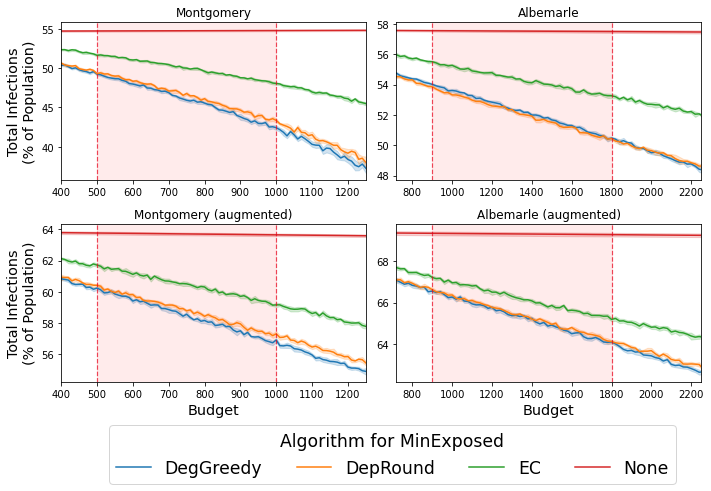

In [19]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_full, (400, 1250), (500, 1000)),
        data_info("Albemarle", df_cville_full, (720, 2250), (900, 1800)), 
        data_info("Montgomery (augmented)", df_mont_star_full,(400, 1250), (500, 1000)),
        data_info("Albemarle (augmented)", df_cville_star_full, (720, 2250), (900, 1800))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2+col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        a.axvline(x=data[row*2+col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvline(x=data[row*2+col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvspan(data[row*2+col].x_range[0], data[row*2+col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2+col].x_lim[0],data[row*2+col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
    
        a.set_title(data[row*2 + col].title)

fig.tight_layout()

legend = fig.legend(["DegGreedy", "DepRound", "EC", "None"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
#legend = fig.legend(["DegGreedy", "DepRound", "EC", "None"], title='Algorithm for MinExposed',loc = "upper left", ncol = 1, bbox_to_anchor = (1, 0.96), fontsize = "xx-large")
#legend = fig.legend(["DegGreedy", "DepRound", "EC", "None"], title='Algorithm for MinExposed', loc = "center left", ncol = 1, bbox_to_anchor = (1, 0.5), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')
#fig.savefig("../output/plots/budget_sensitivity_full_3.png", dpi=500, bbox_inches = 'tight')
#fig.savefig("../output/plots/budget_sensitivity_full_3_side.png", dpi=500, bbox_inches = 'tight')

In [20]:
fig.savefig("../output/plots/budget_sensitivity_full.png", dpi=500, bbox_inches = 'tight')

##### Peak Plots

[None, None]

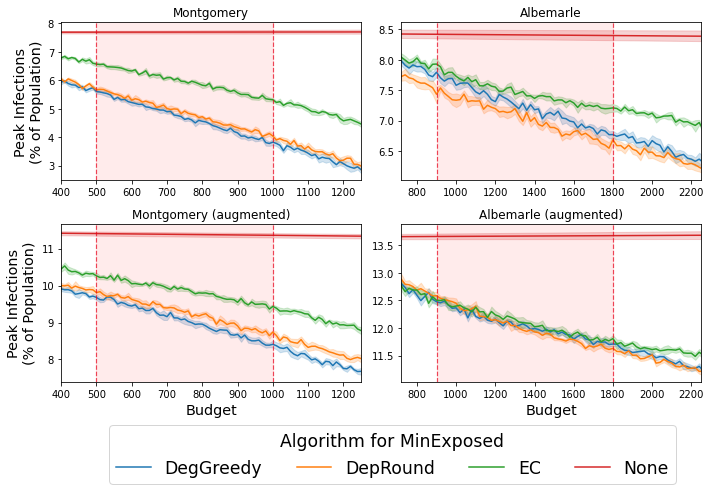

In [21]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_full, (400, 1250), (500, 1000)),
        data_info("Albemarle", df_cville_full, (720, 2250), (900, 1800)), 
        data_info("Montgomery (augmented)", df_mont_star_full,(400, 1250), (500, 1000)),
        data_info("Albemarle (augmented)", df_cville_star_full, (720, 2250), (900, 1800))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2+col].df, x="budget", y="peak", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        a.axvline(x=data[row*2+col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvline(x=data[row*2+col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvspan(data[row*2+col].x_range[0], data[row*2+col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2+col].x_lim[0],data[row*2+col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Peak Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
    
        a.set_title(data[row*2 + col].title)

fig.tight_layout()

legend = fig.legend(["DegGreedy", "DepRound", "EC", "None"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

In [22]:
fig.savefig("../output/plots/budget_sensitivity_full_peak.png", dpi=500, bbox_inches = 'tight')

#### Manual Budget Sensitivity

##### Total Infection Plots (w/ augmentation)

[None, None]

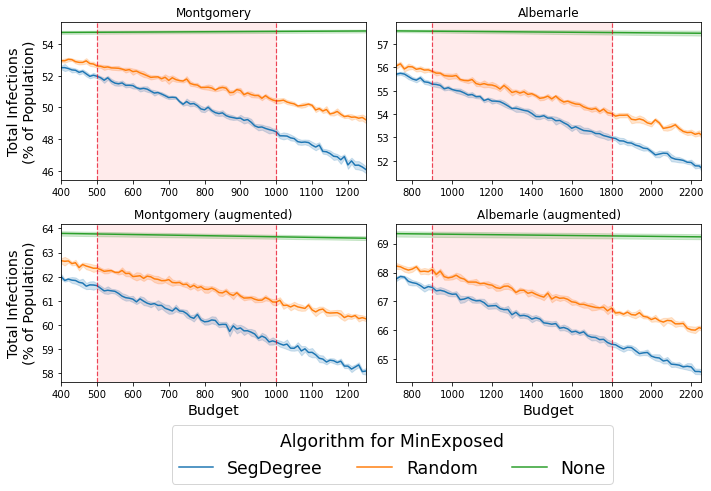

In [23]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_manual,(400, 1250), (500, 1000)),
        data_info("Albemarle", df_cville_manual, (720, 2250), (900, 1800)),
        data_info("Montgomery (augmented)",df_mont_star_manual,(400, 1250), (500, 1000)),
        data_info("Albemarle (augmented)", df_cville_star_manual, (720, 2250), (900, 1800))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2+col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        a.axvline(x=data[row*2+col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvline(x=data[row*2+col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvspan(data[row*2+col].x_range[0], data[row*2+col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2+col].x_lim[0],data[row*2+col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
        
        a.set_title(data[row*2 + col].title)

fig.tight_layout()

legend = fig.legend(["SegDegree", "Random", "None"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
#legend = fig.legend(["SegDegree", "Random", "None"], title='Algorithm for MinExposed',loc = "center left", ncol = 1, bbox_to_anchor = (1, 0.5), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

#fig.savefig("../output/plots/budget_sensitivity_manual_side.png", dpi=500, bbox_inches = 'tight')

##### Total Infection Plots (w/o augmentation)

[None, None]

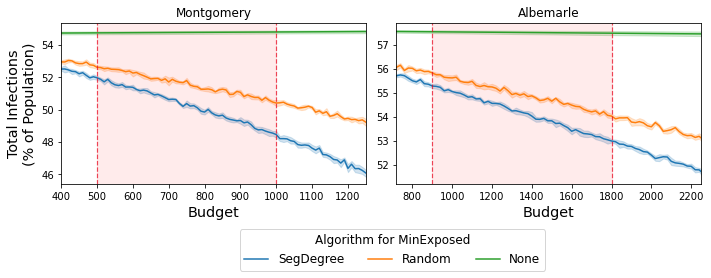

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10,3.25))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_manual,(400, 1250), (500, 1000)),
        data_info("Albemarle", df_cville_manual, (720, 2250), (900, 1800))]

row = 0
for col, a in enumerate(ax):
    ax_plot = sns.lineplot(data=data[row*2+col].df, x="budget", y="infected", hue="Alg for MinExposed", ax= a)
    ax_plot.get_legend().remove()
    a.axvline(x=data[row*2+col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
    a.axvline(x=data[row*2+col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
    a.axvspan(data[row*2+col].x_range[0], data[row*2+col].x_range[1], alpha=0.08, color='red')
    a.set_xlim(data[row*2+col].x_lim[0],data[row*2+col].x_lim[1])

    if col != 0:
        a.set_ylabel("")
    else:
        a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')

    if row != 0:
        a.set_xlabel("")
    else:
        a.set_xlabel("Budget", fontsize='x-large')

    a.set_title(data[row*2 + col].title)

fig.tight_layout()

legend = fig.legend(["SegDegree", "Random", "None"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.2), fontsize = "large")
plt.setp(legend.get_title(), fontsize='large')

In [37]:
fig.savefig("../output/plots/budget_sensitivity_manual_noaugment.png", dpi=500, bbox_inches = 'tight')

##### Peak Infection Plots

[None, None]

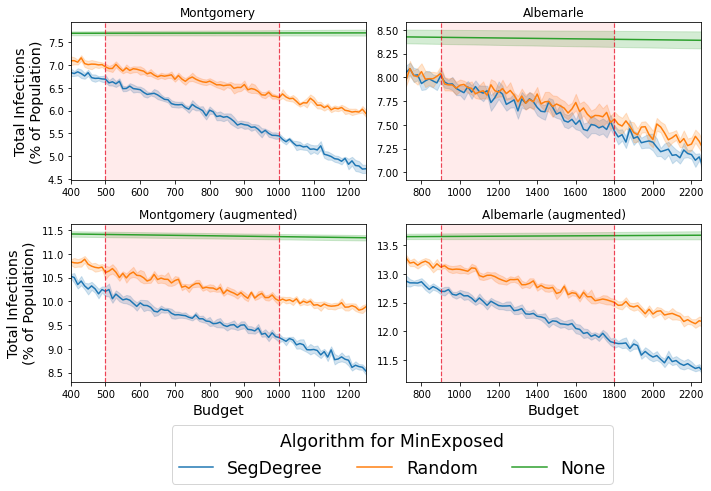

In [25]:
fig, ax = plt.subplots(2,2,figsize=(10,6))

import seaborn as sns

data_info = namedtuple("data_info", ["title", "df", "x_lim", "x_range"])

data = [data_info("Montgomery", df_mont_manual,(400, 1250), (500, 1000)),
        data_info("Albemarle", df_cville_manual, (720, 2250), (900, 1800)),
        data_info("Montgomery (augmented)",df_mont_star_manual, (400, 1250), (500, 1000)),
        data_info("Albemarle (augmented)", df_cville_star_manual, (720, 2250), (900, 1800))]

for row, axs in enumerate(ax):
    
    for col, a in enumerate(axs):
        ax_plot = sns.lineplot(data=data[row*2+col].df, x="budget", y="peak", hue="Alg for MinExposed", ax= a)
        ax_plot.get_legend().remove()
        a.axvline(x=data[row*2+col].x_range[0], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvline(x=data[row*2+col].x_range[1], linewidth=1.2, color=(0.9,0,0.1, 0.7),linestyle='--')
        a.axvspan(data[row*2+col].x_range[0], data[row*2+col].x_range[1], alpha=0.08, color='red')
        a.set_xlim(data[row*2+col].x_lim[0], data[row*2+col].x_lim[1])
        
        if col != 0:
            a.set_ylabel("")
        else:
            a.set_ylabel("Total Infections\n(% of Population)", fontsize='x-large')
        
        if row != len(ax)-1:
            a.set_xlabel("")
        else:
            a.set_xlabel("Budget", fontsize='x-large')
        
        a.set_title(data[row*2 + col].title)

fig.tight_layout()

legend = fig.legend(["SegDegree", "Random", "None"], title='Algorithm for MinExposed',loc = "lower center", ncol = 5, bbox_to_anchor = (0.55, -0.15), fontsize = "xx-large")
plt.setp(legend.get_title(), fontsize='xx-large')

In [26]:
fig.savefig("../output/plots/budget_sensitivity_manual_peak.png", dpi=500, bbox_inches = 'tight')

In [14]:
from fractions import Fraction #we will work with rational numbers

#sample uniformly from range(m)
#all randomness comes from calling this
def sample_uniform(m,rng):
    assert isinstance(m,int) #python 3
    #assert isinstance(m,(int,long)) #python 2
    assert m>0
    return rng.randrange(m)

#sample from a Bernoulli(p) distribution
#assumes p is a rational number in [0,1]
def sample_bernoulli(p,rng):
    assert isinstance(p,Fraction)
    assert 0 <= p <= 1
    m=sample_uniform(p.denominator,rng)
    if m < p.numerator:
        return 1
    else:
        return 0

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number in [0,1]
def sample_bernoulli_exp1(x,rng):
    assert isinstance(x,Fraction)
    assert 0 <= x <= 1
    k=1
    while True:
        if sample_bernoulli(x/k,rng)==1:
            k=k+1
        else:
            break
    return k%2

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number >=0
def sample_bernoulli_exp(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    #Sample floor(x) independent Bernoulli(exp(-1))
    #If all are 1, return Bernoulli(exp(-(x-floor(x))))
    while x>1:
        if sample_bernoulli_exp1(Fraction(1,1),rng)==1:
            x=x-1
        else:
            return 0
    return sample_bernoulli_exp1(x,rng)

#sample from a geometric(1-exp(-x)) distribution
#assumes x is a rational number >= 0
def sample_geometric_exp_slow(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    k=0
    while True:
        if sample_bernoulli_exp(x,rng)==1:
            k=k+1
        else:
            return k
            
#sample from a geometric(1-exp(-x)) distribution
#assumes x >= 0 rational
def sample_geometric_exp_fast(x,rng):
    assert isinstance(x,Fraction)
    if x==0: return 0 #degenerate case
    assert x>0

    t=x.denominator
    while True:
        u=sample_uniform(t,rng)
        b=sample_bernoulli_exp(Fraction(u,t),rng)
        if b==1:
            break
    v=sample_geometric_exp_slow(Fraction(1,1),rng)
    value = v*t+u
    return value//x.numerator
    
#sample from a discrete Laplace(scale) distribution
#Returns integer x with Pr[x] = exp(-abs(x)/scale)*(exp(1/scale)-1)/(exp(1/scale)+1)
#casts scale to Fraction
#assumes scale>=0
def sample_dlaplace(scale,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    scale = Fraction(scale)
    assert scale >= 0
    while True:
        sign=sample_bernoulli(Fraction(1,2),rng)
        magnitude=sample_geometric_exp_fast(1/scale,rng)
        if sign==1 and magnitude==0: continue
        return magnitude*(1-2*sign)
        
#compute floor(sqrt(x)) exactly
#only requires comparisons between x and integer
def floorsqrt(x):
    assert x >= 0
    #a,b integers
    a=0 #maintain a^2<=x
    b=1 #maintain b^2>x
    while b*b <= x:
        b=2*b #double to get upper bound
    #now do binary search
    while a+1<b:
        c=(a+b)//2 #c=floor((a+b)/2)
        if c*c <= x:
            a=c
        else:
            b=c
    #check nothing funky happened
    #assert isinstance(a,int) #python 3
    #assert isinstance(a,(int,long)) #python 2
    return a
    
#sample from a discrete Gaussian distribution N_Z(0,sigma2)
#Returns integer x with Pr[x] = exp(-x^2/(2*sigma2))/normalizing_constant(sigma2)
#mean 0 variance ~= sigma2 for large sigma2
#casts sigma2 to Fraction
#assumes sigma2>=0
def sample_dgauss(sigma2,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    sigma2=Fraction(sigma2)
    if sigma2==0: return 0 #degenerate case
    assert sigma2 > 0
    t = floorsqrt(sigma2)+1
    while True:
        candidate = sample_dlaplace(t,rng=rng)
        bias=((abs(candidate)-sigma2/t)**2)/(2*sigma2)
        if sample_bernoulli_exp(bias,rng)==1:
            return candidate
        
#########################################################################
#DONE That's it! Now some utilities

import math #need this, code below is no longer exact

#Compute the normalizing constant of the discrete gaussian
#i.e. sum_{x in Z} exp(-x^2/2sigma2)
#By Poisson summation formula, this is equivalent to
# sqrt{2*pi*sigma2}*sum_{y in Z} exp(-2*pi^2*sigma2*y^2)
#For small sigma2 the former converges faster
#For large sigma2, the latter converges faster
#crossover at sigma2=1/2*pi
#For intermediate sigma2, this code will compute both and check
def normalizing_constant(sigma2):
    original=None
    poisson=None
    if sigma2<=1:
        original = 0
        x=1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0:
            original = original + math.exp(-x*x/(2.0*sigma2))
            x = x - 1 #sum from small to large for improved accuracy
        original = 2*original + 1 #symmetrize and add x=0
    if sigma2*100 >= 1:
        poisson = 0
        y = 1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0:
            poisson = poisson + math.exp(-math.pi*math.pi*sigma2*2*y*y)
            y = y - 1 #sum from small to large
        poisson = math.sqrt(2*math.pi*sigma2)*(1+2*poisson)
    if poisson is None: return original
    if original is None: return poisson
    #if we have computed both, check equality
    scale = max(1,math.sqrt(2*math.pi*sigma2)) #tight-ish lower bound on constant
    assert -1e-15*scale <= original-poisson <= 1e-15*scale
    #10^-15 is about as much precision as we can expect from double precision floating point numbers
    #64-bit float has 56-bit mantissa 10^-15 ~= 2^-50
    return (original+poisson)/2

#compute the variance of discrete gaussian
#mean is zero, thus:
#var = sum_{x in Z} x^2*exp(-x^2/(2*sigma2)) / normalizing_constant(sigma2)
#By Poisson summation formula, we have equivalent expression:
# variance(sigma2) = sigma2 * (1 - 4*pi^2*sigma2*variance(1/(4*pi^2*sigma2)) )
#See lemma 20 https://arxiv.org/pdf/2004.00010v3.pdf#page=17
#alternative expression converges faster when sigma2 is large
#crossover point (in terms of convergence) is sigma2=1/(2*pi)
#for intermediate values of sigma2, we compute both expressions and check
def variance(sigma2):
    original=None
    poisson=None
    if sigma2<=1: #compute primary expression
        original=0
        x = 1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0: #sum from small to large for improved accuracy
            original = original + x*x*math.exp(-x*x/(2.0*sigma2))
            x=x-1
        original = 2*original/normalizing_constant(sigma2)
    if sigma2*100>=1:
        poisson=0 #we will compute sum_{y in Z} y^2 * exp(-2*pi^2*sigma2*y^2)
        y=1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0: #sum from small to large
            poisson = poisson + y*y*math.exp(-y*y*2*sigma2*math.pi*math.pi)
            y=y-1
        poisson = 2*poisson/normalizing_constant(1/(4*sigma2*math.pi*math.pi))
        #next convert from variance(1/(4*pi^2*sigma2)) to variance(sigma2)
        poisson = sigma2*(1-4*sigma2*poisson*math.pi*math.pi)
    if original is None: return poisson
    if poisson is None: return original
    #if we have computed both check equality
    assert -1e-15*sigma2 <= original-poisson <= 1e-15*sigma2
    return (original+poisson)/2

def DegGreedy_private_V2(state: InfectionState, epsilon: float):
    weights: List[Tuple[int, int]] = []
    
    I2 = set(state.SIR.I2)
    for u in state.V1:
        
        deg_noise_V2 = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0])
        infected_nbr_count = len(set(G.neighbors(u)) & I2)
        
        #deg_noise_V2 += sample_dgauss(1/(math.sqrt(2)*epsilon/2))
        deg_noise_V2 += sample_dgauss(1/((1/math.sqrt(10))*epsilon))
        #1/sqrt(10)
        #infected_nbr_count += sample_dgauss(1/(math.sqrt(2)*epsilon/2))
        infected_nbr_count += sample_dgauss(1/((3/math.sqrt(10))*epsilon))
        #3/sqrt(10)
        
        w_sum = state.transmission_rate * max(1, deg_noise_V2)
        
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, infected_nbr_count))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_V2_noisy(state: InfectionState, epsilon: float):
    degrees: List[Tuple[int, int]] = []
    
    for u in state.V1:
        noise = sample_dgauss(1/epsilon)
        count = max(1, sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i] != 0]) + noise)
        degrees.append((count, u))
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

### Albemarle Epicurve Plots

### Degree

In [22]:
def Degree_I(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
    for u in state.V1:
        count = sum([1 for v in state.G.neighbors(u) if v in state.SIR.I2])
        degrees.append((count, u))
        
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

def Degree_total(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
    for u in state.V1:
        count = sum([1 for v in state.G.neighbors(u)])
        degrees.append((count, u))
        
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

def List_Length(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
    
    v1_to_score = {}
    for i in state.SIR.I2:
        v1_neighbors = [v for v in state.G.neighbors(i) if v in state.V1]
        
        for v in v1_neighbors:
        
            if v in v1_to_score:
                v1_to_score[v] += 1/len(v1_neighbors)
            else:
                v1_to_score[v] = 1/len(v1_neighbors)
    
    degrees = [(value, key) for key, value in v1_to_score.items()]
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

### Digital DegGreedy ###

In [2]:
import random #Default random number generator,
#random.SecureRandom() provides high-quality randomness from /dev/urandom or similar
from fractions import Fraction #we will work with rational numbers

#sample uniformly from range(m)
#all randomness comes from calling this
def sample_uniform(m,rng):
    assert isinstance(m,int) #python 3
    #assert isinstance(m,(int,long)) #python 2
    assert m>0
    return rng.randrange(m)

#sample from a Bernoulli(p) distribution
#assumes p is a rational number in [0,1]
def sample_bernoulli(p,rng):
    assert isinstance(p,Fraction)
    assert 0 <= p <= 1
    m=sample_uniform(p.denominator,rng)
    if m < p.numerator:
        return 1
    else:
        return 0

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number in [0,1]
def sample_bernoulli_exp1(x,rng):
    assert isinstance(x,Fraction)
    assert 0 <= x <= 1
    k=1
    while True:
        if sample_bernoulli(x/k,rng)==1:
            k=k+1
        else:
            break
    return k%2

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number >=0
def sample_bernoulli_exp(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    #Sample floor(x) independent Bernoulli(exp(-1))
    #If all are 1, return Bernoulli(exp(-(x-floor(x))))
    while x>1:
        if sample_bernoulli_exp1(Fraction(1,1),rng)==1:
            x=x-1
        else:
            return 0
    return sample_bernoulli_exp1(x,rng)

#sample from a geometric(1-exp(-x)) distribution
#assumes x is a rational number >= 0
def sample_geometric_exp_slow(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    k=0
    while True:
        if sample_bernoulli_exp(x,rng)==1:
            k=k+1
        else:
            return k
            
#sample from a geometric(1-exp(-x)) distribution
#assumes x >= 0 rational
def sample_geometric_exp_fast(x,rng):
    assert isinstance(x,Fraction)
    if x==0: return 0 #degenerate case
    assert x>0

    t=x.denominator
    while True:
        u=sample_uniform(t,rng)
        b=sample_bernoulli_exp(Fraction(u,t),rng)
        if b==1:
            break
    v=sample_geometric_exp_slow(Fraction(1,1),rng)
    value = v*t+u
    return value//x.numerator
    
#sample from a discrete Laplace(scale) distribution
#Returns integer x with Pr[x] = exp(-abs(x)/scale)*(exp(1/scale)-1)/(exp(1/scale)+1)
#casts scale to Fraction
#assumes scale>=0
def sample_dlaplace(scale,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    scale = Fraction(scale)
    assert scale >= 0
    while True:
        sign=sample_bernoulli(Fraction(1,2),rng)
        magnitude=sample_geometric_exp_fast(1/scale,rng)
        if sign==1 and magnitude==0: continue
        return magnitude*(1-2*sign)

(array([ 1.,  1.,  2.,  3., 10., 24., 40., 13.,  3.,  3.]),
 array([-12. , -10.1,  -8.2,  -6.3,  -4.4,  -2.5,  -0.6,   1.3,   3.2,
          5.1,   7. ]),
 <BarContainer object of 10 artists>)

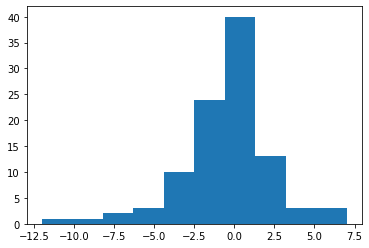

In [60]:
import matplotlib.pyplot as plt
plt.hist([sample_dlaplace(1/(1/2)) for i in range(100)])

In [21]:
epsilon = 2
import networkx as nx

def DegGreedy_private(state: InfectionState):
    
    weights: List[Tuple[int, int]] = []
    
    noises = []
    
    for u in state.V1:
        noise = sample_dgauss(1/(epsilon))
        noises.append(noise)
        deg_noise = len(set(state.G.neighbors(u))) + noise
        #deg_noise = len(set(state.G.neighbors(u)))
        w_sum = state.transmission_rate * max(1, deg_noise)
        
        #infected_nbr_count = len(set(G.neighbors(u)) & set(state.SIR.I2))
        #probability_infected = 1 - math.pow(1-state.transmission_rate, 
        #                                    max(1, infected_nbr_count + sample_dgauss(1/(epsilon))))
        
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                                        max(1, deg_noise//10))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    #plt.hist(noises)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_total_noisy(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
        
    noises = []
    
    for u in state.V1:
        noise = sample_dgauss(1/epsilon)
        noises.append(noise)
        count = max(1, len(set(state.G.neighbors(u))) + noise)
        degrees.append((count, u))
    
    plt.hist(noises)
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}

In [26]:
epsilon = 1
import networkx as nx

def DegGreedy_private_V2(state: InfectionState):
    
    weights: List[Tuple[int, int]] = []
    
    noises = []
    
    for u in state.V1:
        noise = sample_dlaplace(sqrt(2)/(epsilon/2))
        noises.append(noise)
        #deg_noise = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0]) + noise
        
        deg_I = 0
        deg_V2 = 0
        for i in set(state.G.neighbors(u)):
            if i in state.SIR.I2:
                deg_I += 1
            elif i in state.V2:
                deg_V2 += 1
        
        deg_noise_V2 = deg_V2 + noise
        deg_noise_I = deg_I + sample_dlaplace(sqrt(2)/(epsilon/2))
        
        w_sum = state.transmission_rate * max(1, deg_noise_V2)
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, deg_noise_I))
        
        #deg_noise_V2 = sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i]!=0]) + noise
        #deg_noise = len(set(state.G.neighbors(u)))
        
        '''w_sum = state.transmission_rate * max(1, deg_noise_V2)
        
        infected_nbr_count = len(set(G.neighbors(u)) & set(state.SIR.I2))
        probability_infected = 1 - math.pow(1-state.transmission_rate, 
                                            max(1, infected_nbr_count + sample_dgauss(1/(epsilon/2))))'''
        
        #probability_infected = 1 - math.pow(1-state.transmission_rate, 
        #                                                max(1, deg_noise))
        
        weights.append((probability_infected * (w_sum), u))

    weights.sort(reverse=True)
    #plt.hist(noises)
    
    return {i[1] for i in weights[:state.budget]}

def Degree_V2_noisy(state: InfectionState):
    degrees: List[Tuple[int, int]] = []
        
    noises = []
    
    for u in state.V1:
        noise = sample_dgauss(1/epsilon)
        noises.append(noise)
        count = max(1, sum([1 for i in set(state.G.neighbors(u)) if i in state.V2 and state.Q[u][i] != 0]) + noise)
        degrees.append((count, u))
    
    plt.hist(noises)
    
    degrees.sort(reverse=True)
    return {i[1] for i in degrees[:state.budget]}